# Introduction

Transfer learning over VGG 16 (pretratied on imagenet) and ensemble using LGBM.

Transfer learning is **training a pre-trained model (a model which trained on a big dataset, such as VGG16 model has trained on ImageNet which has 1000 classes and thousands of images.) using our data.** Maybe you can think *but it has 1000 classes and our data does not have 1000 classes*. We'll drop the fully connected layers, only use convolution layers. 

# Table of Content
1. Preparing Environment
1. Preparing Data
1. Preparing VGG16
1. Training VGG16
1. Conclusion


# Preparing Environment
In this section we're going to import libraries we'll use and read the paths of the images.


In [1]:
!pip install torchsummary

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from sklearn import metrics


In [3]:
brown_spot = glob("../input/riceleafs/RiceLeafs/train/BrownSpot/*") + glob("../input/riceleafs/RiceLeafs/validation/BrownSpot/*")
healthy = glob("../input/riceleafs/RiceLeafs/train/Healthy/*") + glob("../input/riceleafs/RiceLeafs/validation/Healthy/*")
hispa = glob("../input/riceleafs/RiceLeafs/train/Hispa/*") + glob("../input/riceleafs/RiceLeafs/validation/Hispa/*")
leaf_blast = glob("../input/riceleafs/RiceLeafs/train/LeafBlast/*") + glob("../input/riceleafs/RiceLeafs/validation/LeafBlast/*")

print("Number of brown spot:",len(brown_spot))
print("Number of healthy:",len(healthy))
print("Number of hispa: ",len(hispa))
print("Number of leaf blast:",len(leaf_blast))


Number of brown spot: 523
Number of healthy: 1488
Number of hispa:  565
Number of leaf blast: 779


In [4]:
label_map = {0:"brown_spot",
             1:"healthy",
             2:"hispa",
             3:"leaf_blast"
            }

# Preparing Data

In this section we're going to create a custom dataset class, sampler and loader objects.

In [5]:
class LeafDataset(Dataset):
    
    def __init__(self,paths):
        
        self.x = []
        self.y = []                         # This converts pil image to torch tensor.
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             # We have to normalize data to use in torchvision models.
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],                                     std=[0.229, 0.224, 0.225])
                                            ])
        
        start = time.time()
        for label,class_paths in enumerate(paths):
            for sample_path in class_paths:
                img = Image.open(sample_path).resize((224,224))
                self.x.append(self.transform(img))
                self.y.append(label)
        end = time.time()
        process_time = round(end-start,2)
        print("Dataset has loaded, that took {} seconds".format(process_time))
        
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return len(self.x)


In [6]:
dataset = LeafDataset((brown_spot,healthy,hispa,leaf_blast))

Dataset has loaded, that took 609.34 seconds


* Now let's get 20 random samples and see how our data seems.

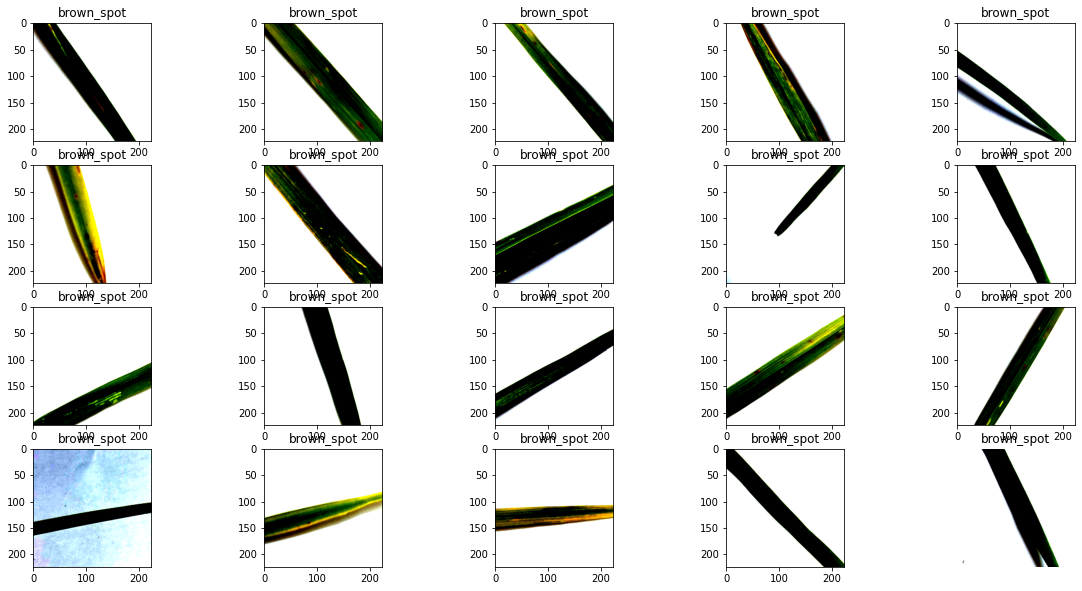

In [7]:
random_sample_indexes = random.choices(range(len(dataset)),k=20)

fig, axis = plt.subplots(4,5, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        
        image,label = dataset[i]
        
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[label]
        ax.imshow(npimg)
        ax.set(title = f"{label}")
        plt.axis("off")

In [8]:
np.unique(dataset.y)

array([0, 1, 2, 3])

* Now we'll create subset samplers.


In [9]:
# Splitting indices into train and test sets.
train,test = train_test_split(list(range(len(dataset))))
print(len(train))
print(len(test))

2516
839


In [10]:
train_sampler = SubsetRandomSampler(train)
test_sampler = SubsetRandomSampler(test)

* And finally we can create our loader objects.

In [11]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,sampler=test_sampler)


# Preparing VGG16
In this section we're going to load and prepare our VGG16 model.

In [12]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True)

# In transfer learning we don't need to train all layers, 
# actually in this mission we'll just train fully connected layers
# other's will be pre-trained

for param in vgg16.features.parameters():
    param.require_grad = False

# This will return how many features we'll have after flattening.
num_features = vgg16.classifier[6].in_features
num_features

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

4096

* As you see we have 4096 features before the prediction layer, so we'll add a linear layer (in=4096,out=4)

In [ ]:
# We did not get the last layer (prediction layer) 
# we'll add our prediction layer.
layers = list(vgg16.classifier.children())[:-1]

layers.append(nn.Linear(num_features,4))

vgg16.classifier = nn.Sequential(*layers)

In [ ]:
summary(vgg16.cuda(), (3, 224, 224))

* Done, now we can train our model.

# Training VGG16
Trainging vgg 16 over our dataset for 30 epoch results 99% - 100% accuracy over traing dataset.

In [13]:
# In order to work with gpu, we need to create a device object
device = torch.device("cuda")
print(device)

cuda


In [15]:
# Also we need an optimizer and a loss function
# We'll use RMSprop as optimizer and cross entropy as loss

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(vgg16.parameters(),lr=1e-4)

In [16]:
vgg16 = vgg16.to(device)

In [ ]:
EPOCH_NUMBER = 30

for current_epoch in range(1,EPOCH_NUMBER+1):
    epoch_total_train_loss = 0.0
    epoch_total_train_true = 0
    epoch_total_data_len = 0
    
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        
        # Cleaning cached gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = vgg16(images)
        
        # Backward propagation
        loss = criterion(outputs,labels)
        loss.backward()
        
        # Optimizing
        optimizer.step()
        
        epoch_total_train_loss += loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_total_train_true += torch.sum(pred == labels).item()
        epoch_total_data_len += labels.size(0)
    
    acc = round(100 * epoch_total_train_true / epoch_total_data_len,2)
    print(f"Epoch {current_epoch} completed: Train loss: {epoch_total_train_loss} Train Accuracy: {acc}")
        

* We've trained our model, let's compute validation loss and validation accuracy.

In [ ]:
validation_loss = 0.0
validation_correct = 0
validation_total = len(test_sampler)

with torch.no_grad():
    vgg16.eval()
    for data_,target_ in test_loader:
        data_,target_ = data_.to(device),target_.to(device)
        
        outputs = vgg16(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        correct = torch.sum(preds == target_).item()
        validation_loss += loss
        validation_correct += correct

validation_accuracy = round(100 * validation_correct / validation_total,2)
print(f"Validation accuracy: {validation_accuracy}, Validation loss: {validation_loss}")

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-3])

In [ ]:
summary(vgg16.cuda(), (3, 224, 224))

In [ ]:
#torch.save(vgg16,'model.pth')

#### FROM PREVIOUSLY TRAINED MODEL

In [ ]:
vgg16 = torch.load('../input/vgg16-model/model 2.pth')

In [ ]:
device = torch.device("cuda")
print(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(vgg16.parameters(),lr=1e-4)

In [ ]:
vgg16 = vgg16.to(device)

In [56]:
summary(vgg16.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [18]:
X_train = []
Y_train = []
with torch.no_grad():
    for data_,target_ in train_loader:
        data_,target_ = data_.to(device),target_.to(device)
        outputs = vgg16(data_)
        X_train.append(outputs)
        Y_train.append(target_)
        

In [19]:
X_train_np = np.zeros([1, 4096])
for i in range(len(X_train)):
    arr = X_train[i].cpu().numpy()
    X_train_np = np.concatenate((X_train_np, arr), axis=0)

In [20]:
Y_train_np = np.zeros([1,])
for i in range(len(X_train)):
    arr = Y_train[i].cpu().numpy()
    Y_train_np = np.concatenate((Y_train_np, arr), axis=0)

In [21]:
X_train = X_train_np[1:,:]

In [22]:
Y_train = Y_train_np[1:]

In [23]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=Y_train)

lgbm_params = {'learning_rate':0.09, 'boosting_type':'dart',
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':8,
              'max_depth':10,
              'num_class':4}  #no.of unique values in the target class not inclusive of the end value

lgb_model = lgb.train(lgbm_params, d_train, 10) 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044480
[LightGBM] [Info] Number of data points in the train set: 2516, number of used features: 4096
[LightGBM] [Info] Start training from score -1.898180
[LightGBM] [Info] Start training from score -0.801338
[LightGBM] [Info] Start training from score -1.778336
[LightGBM] [Info] Start training from score -1.458814


In [24]:
X_test = []
Y_test = []
with torch.no_grad():
    for data_,target_ in test_loader:
        data_,target_ = data_.to(device),target_.to(device)
        outputs = vgg16(data_)
        X_test.append(outputs)
        Y_test.append(target_)

In [25]:
X_test_np = np.zeros([1, 4096])
for i in range(len(X_test)):
    arr = X_test[i].cpu().numpy()
    X_test_np = np.concatenate((X_test_np, arr), axis=0)

In [26]:
Y_test_np = np.zeros([1,])
for i in range(len(Y_test)):
    arr = Y_test[i].cpu().numpy()
    Y_test_np = np.concatenate((Y_test_np, arr), axis=0)

In [27]:
X_test = X_test_np[1:,:]
Y_test = Y_test_np[1:]

In [28]:
prediction_lgb=lgb_model.predict(X_test)

In [32]:
prediction_lgb

array([[0.05559052, 0.79763556, 0.06316443, 0.08360949],
       [0.05559052, 0.79763556, 0.06316443, 0.08360949],
       [0.05559052, 0.79763556, 0.06316443, 0.08360949],
       ...,
       [0.06289271, 0.50124801, 0.33964945, 0.09620983],
       [0.06554728, 0.16375678, 0.67211124, 0.0985847 ],
       [0.07066443, 0.76137596, 0.07228173, 0.09567788]])

In [29]:
prediction_lgbm = np.array([np.argmax(i) for i in prediction_lgb])
print ("Accuracy with LGBM = ", metrics.accuracy_score(Y_test, prediction_lgbm))

Accuracy with LGBM =  0.9618593563766389


In [33]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test,prediction_lgbm)

print(cf_matrix)

[[141   3   0   2]
 [  2 351   6   0]
 [  0  10 130   0]
 [  2   5   2 185]]


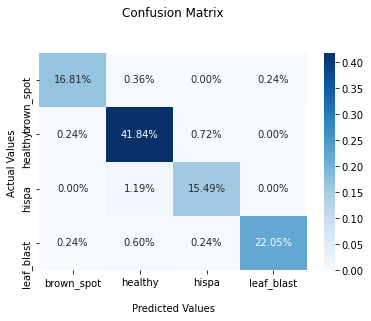

In [38]:
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["brown_spot","healthy","hispa","leaf_blast"])
ax.yaxis.set_ticklabels(["brown_spot","healthy","hispa","leaf_blast"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [47]:
from sklearn.preprocessing import OneHotEncoder
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y_test.reshape(len(Y_test), 1)
Y_onehot = onehot_encoder.fit_transform(integer_encoded)

In [48]:
Y_onehot

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [50]:
from sklearn.metrics import roc_curve, auc

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_onehot[:, i],prediction_lgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

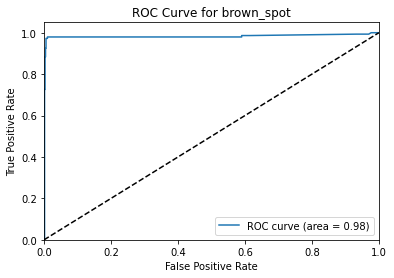

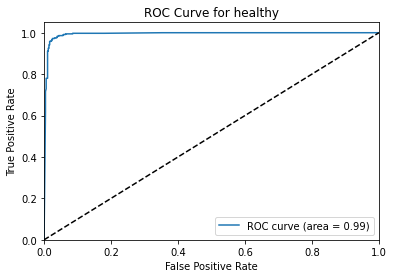

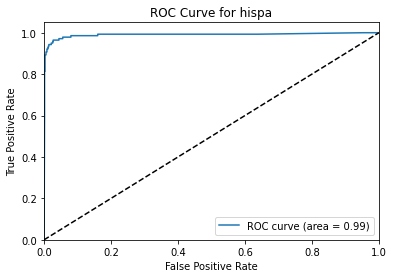

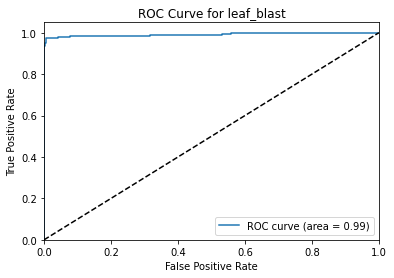

In [52]:
label_map = {0:"brown_spot",
             1:"healthy",
             2:"hispa",
             3:"leaf_blast"
            }
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {label}'.format(label = label_map[i]))
    plt.legend(loc="lower right")
    plt.show()

* Validation accuracy is pretty worse but we can handle this problem using data augmentation techniques and I'll learn (and also show you xD) it in the next kernel.


In [54]:
from sklearn.metrics import classification_report
target_names = ["brown_spot","healthy", "hispa","leaf_blast"]
print(classification_report(Y_test,prediction_lgbm , target_names=target_names))

              precision    recall  f1-score   support

  brown_spot       0.97      0.97      0.97       146
     healthy       0.95      0.98      0.96       359
       hispa       0.94      0.93      0.94       140
  leaf_blast       0.99      0.95      0.97       194

    accuracy                           0.96       839
   macro avg       0.96      0.96      0.96       839
weighted avg       0.96      0.96      0.96       839



# Conclusion
Highest accuracy with LGBM =  0.9618593563766389 over validation dataset
